In [13]:
import cv2
import matplotlib.pyplot as plt
inline = True
from IPython.display import display
# Define the region of interest for segmentation
x_start_seg_part, y_start_seg_part, x_end_seg, y_end_seg = [2, 600, 1200, 750]

def preprocess_frame(frame):
    """Apply adaptive thresholding and morphological transformations to preprocess the frame."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    GEAY = cv2.GaussianBlur(gray, (5, 5), sigmaX=0 , sigmaY=0)
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 2
    )
    kernel_opening = np.ones((5, 5), np.uint8)
    kernel_closing = np.ones((2, 2), np.uint8)

    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_opening, iterations=1)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_closing, iterations=2)

    return closing


In [8]:

def non_max_suppression(boxes, overlapThresh):
    """Perform non-maximum suppression to eliminate redundant overlapping boxes."""
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(
            idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0]))
        )

    return boxes[pick].astype("int")


In [9]:

def detect_captions(frame):
    """Detect caption areas in the frame and return the processed frame with bounding boxes."""
    closing = preprocess_frame(frame)

    contours, _ = cv2.findContours(closing, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    coordinates = []

    rgba_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2BGRA)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        if (
            x >= x_start_seg_part
            and y >= y_start_seg_part
            and (x + w) <= x_end_seg+1 
            and (y + h) <= y_end_seg and (y + h)>y_start_seg_part
        ):
            coordinates.append([x, y, w, h])

    # Apply Non-Maximum Suppression to remove overlapping boxes
    coordinates = non_max_suppression(coordinates, 0.3)

    for x, y, w, h in coordinates:
        cv2.rectangle(rgba_frame, (x, y), (x + w, y + h), (0, 255, 0, 255), 2)

    return rgba_frame, coordinates



In [10]:

def group_lines(coordinates):
    """Group bounding boxes into lines based on their vertical positions."""
    if len(coordinates) == 0:
        return []

    # Sort coordinates by their y position (top to bottom)
    coordinates = sorted(coordinates, key=lambda x: x[1])

    lines = []
    current_line = [coordinates[0]]

    for box in coordinates[1:]:
        x, y, w, h = box
        last_x, last_y, last_w, last_h = current_line[-1]

        # If the y difference is small enough, consider it the same line
        if abs(y - last_y) <= h // 2:
            current_line.append(box)
        else:
            lines.append(current_line)
            current_line = [box]

    if current_line:
        lines.append(current_line)

    return lines



TypeError: unhashable type: 'numpy.ndarray'

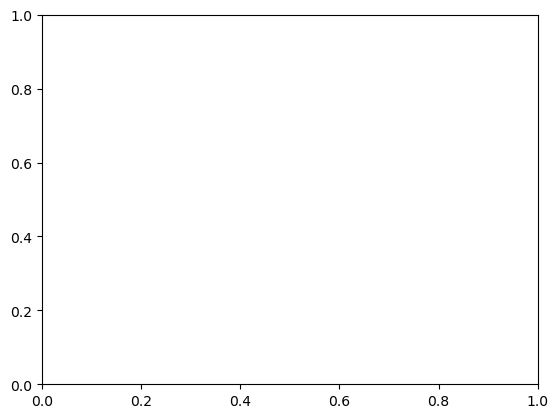

In [20]:

cap = cv2.VideoCapture("Project Video.mp4")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    detected_image, coordinates = detect_captions(frame)
    lines = group_lines(coordinates)
    detected_image_with_lines = draw_lines(detected_image, lines)

    cropped_part = detected_image_with_lines[
        y_start_seg_part:y_end_seg, x_start_seg_part:x_end_seg
    ]

    # Create the final segmented caption part image
    segmented_caption_part_image = frame.copy()
    segmented_caption_part_image[
        y_start_seg_part:y_end_seg, x_start_seg_part:x_end_seg
] = cropped_part[:, :, :3]
    plt.imshow('Frame',frame)
    plt.imshow("Segmented Captions", segmented_caption_part_image)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()